# 1.Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification')

Mounted at /content/gdrive


# 2.Import the necessary libraries

In [ ]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.9.2
numpy:       1.21.6
matplotlib:  3.2.2
sklearn:     1.0.2


# 3.Prepare data for training and testing

In [ ]:
batch_size = 16
epochs = 100

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=20, vertical_flip=False, validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = train_datagen.flow_from_directory(
    directory='/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/5class/train',
    target_size = (224,224),
    class_mode="categorical", batch_size=batch_size, shuffle=True, subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    directory='/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/5class/train', 
    target_size = (224,224),
    class_mode="categorical", batch_size=batch_size, shuffle=True, subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/5class/test',
    target_size = (224,224),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

Found 1318 images belonging to 5 classes.
Found 327 images belonging to 5 classes.
Found 413 images belonging to 5 classes.


In [ ]:
len(train_generator)

83

In [ ]:
len(validation_generator)

21

In [ ]:
print(labels)

{0: 'Carton', 1: 'Glass', 2: 'Metal', 3: 'Plastic', 4: 'Trash'}


# 4.1 define deep learning model(self designed)




In [ ]:
optmz = optimizers.Nadam(lr = 0.0005)
modelname = '5class'

def createModel():
   model   = Sequential() 
   model.add(Conv2D(16,(3,3), 
        input_shape=(224,224,3),  
        padding='same', 
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(1e-4)))
   model.add(BatchNormalization())
   model.add(MaxPooling2D(pool_size=(2,2)))
   model.add(Conv2D(16,(3,3),
        padding='same', 
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(1e-4)))
   model.add(BatchNormalization())
   model.add(MaxPooling2D(pool_size=(2,2)))
   model.add(Conv2D(32,(3,3),
        padding='same', 
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(1e-4)))
   model.add(BatchNormalization())
   model.add(MaxPooling2D(pool_size=(4,4)))
   model.add(Conv2D(64,(3,3),
        padding='same', 
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=l2(1e-4)))
   model.add(BatchNormalization())
   model.add(MaxPooling2D(pool_size=(2,2)))
   model.add(Flatten())
   model.add(Dropout(0.4))
   model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
   model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
   model.add(Dense(5,activation='softmax',kernel_initializer='he_normal'))
   model.compile(loss='categorical_crossentropy',  
          optimizer=optmz,  
          metrics=['accuracy'])
   return model

model = createModel()
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                        

# 4.2 mobilenetv2 based(finally adopted)

In [ ]:
optmz = optimizers.Nadam(lr = 0.0005)
modelname = '5class_mob'

base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                        include_top=False)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.AveragePooling2D(pool_size=(7,7)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(5,activation='softmax',kernel_initializer='he_normal')
])

model.compile(loss='categorical_crossentropy',  
       optimizer=optmz,  
       metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 5)                

# 5.Create the callbacks to be applied during training

In [ ]:
def lrSchedule(epoch):
    lr = 0.0005
           
    if epoch > 90:
        lr *= 1e-3       
    elif epoch > 70:
        lr *= 1e-2     
    elif epoch > 50:
        lr *= 1e-1
        
    print('Learning rate: ', lr)
    return lr

LRScheduler = LearningRateScheduler(lrSchedule)

folderpath = '/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/colab/'
filepath = folderpath + modelname + ".h5"
checkpoint = ModelCheckpoint(filepath, 
               monitor='val_accuracy', 
               verbose=0, 
               save_best_only=True, 
               mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       
callbacks_list  = [checkpoint,csv_logger,LRScheduler]                                       

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])

print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/colab/5class_mob.h5
Path to log:   /content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/colab/5class_mob.csv


In [ ]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/colab/5class_mob_plot.png


# 6.Train the deep learning model with image augmentation

In [ ]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Learning rate:  0.0005
Epoch 1/100
83/83 [==============================] - 491s 6s/step - loss: 1.0022 - accuracy: 0.5994 - val_loss: 0.6169 - val_accuracy: 0.7737 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 2/100
83/83 [==============================] - 22s 266ms/step - loss: 0.5408 - accuracy: 0.8096 - val_loss: 0.6041 - val_accuracy: 0.7920 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 3/100
83/83 [==============================] - 22s 268ms/step - loss: 0.4318 - accuracy: 0.8384 - val_loss: 0.4389 - val_accuracy: 0.8502 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 4/100
83/83 [==============================] - 22s 261ms/step - loss: 0.3759 - accuracy: 0.8619 - val_loss: 0.4336 - val_accuracy: 0.8318 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 5/100
83/83 [==============================] - 23s 279ms/step - loss: 0.3173 - accuracy: 0.8847 - val_loss: 0.4051 - val_accuracy: 0.8654 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 6/100
83/83 [==============================] - 22s 26

# 7.Test and evaluate models

In [ ]:
model_loss, model_acc= model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

26/26 [==============================] - 116s 5s/step - loss: 0.2154 - accuracy: 0.9322
Model has a loss of 0.22 and accuracy 93.22%


In [ ]:
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array

img = load_img('/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/truetest/plastic01.jpg', target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

model = load_model('/content/gdrive/My Drive/MTech in IS/5002Project/Garbage Classification/colab/5class_mob.h5')
prediction = model.predict(img_tensor)
labels[np.argmax(prediction)]

1/1 [==============================] - 1s 1s/step


'Glass'

# 8.Plot curves on validation loss and accuracy

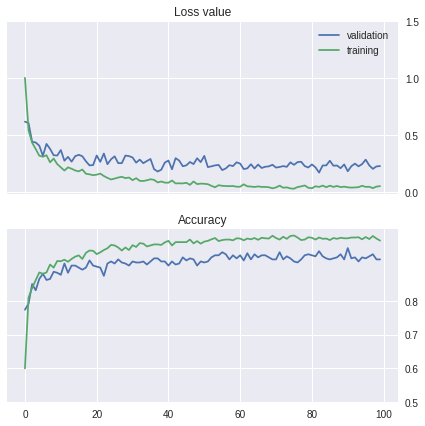

In [ ]:
records     = pd.read_csv(folderpath+modelname +'.csv')

plt.style.use('seaborn')
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]

plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()